# Прогнозирование уровня средней заработной платы в России

In [80]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


Предоставленный датасет имеет данные о изменении среднего уровня заработной платы в России с 01.01.1993 по 01.07.2019. Анализирую соответсвующий временной ряд, необходимо сделать предсказания о изменении среднего уровня зарплаты в будущем.

In [81]:
data = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [82]:
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


Начнём с визуального анализа ряда. На графике присутствуют ярко выраженные тренд и сезонность. Мы видим, что с каждым годом уровень средней заработной платы возрастает. При этом примерно до 2008 года тренд можно описать скорее как квадратичный, так как заметна некоторая выпуклость ряда. Начиная с 2009 зависимость скорее линейная. Так же имеет место меняющаяся во времени дисперсия. Отсечем от данных все, что ранее 2009. Это вполне уместно, так как прогнозировать мы будем будущее, следующее непосредственно за отрезком с линейной зависимостью, учитывание квадратичной зависмости может быть вредно для предсказывающей модели. В данный момент законы, по которым менялась заработная плата в России до 2009 не актуальны.

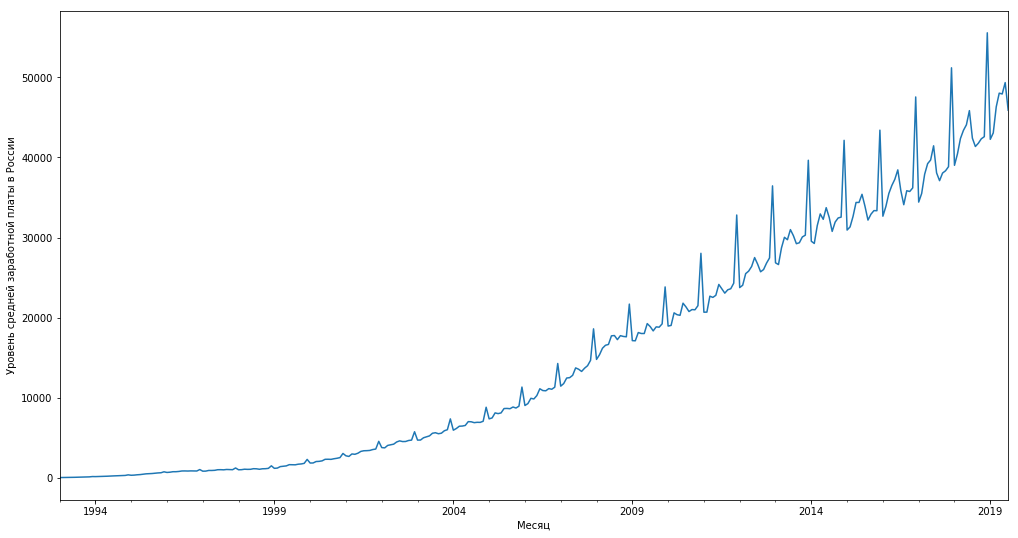

In [83]:
plt.figure(figsize(17,9))
data.WAG_C_M.plot()
plt.ylabel(u'Уровень средней заработной платы в России')
plt.xlabel(u'Месяц')
pylab.show()

После урезания данных линейный тренд на графике становится ещё более заметным.

In [84]:
data = data[data.index >= pd.to_datetime('1/1/2009')]

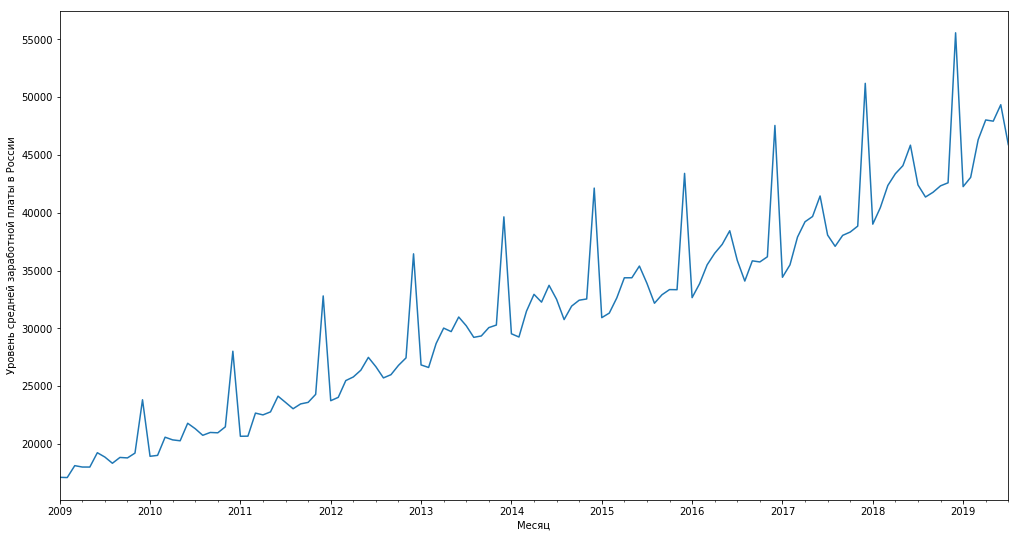

In [85]:
plt.figure(figsize(17,9))
data.WAG_C_M.plot()
plt.ylabel(u'Уровень средней заработной платы в России')
plt.xlabel(u'Месяц')
pylab.show()

Критерий Дики-Фуллера даёт достигаемый уровень значимости $p = 0.991220$. Нестационарность ряда и так очевидна, с учётом вышеперечисленного.

Критерий Дики-Фуллера: p=0.991220


<Figure size 1080x720 with 0 Axes>

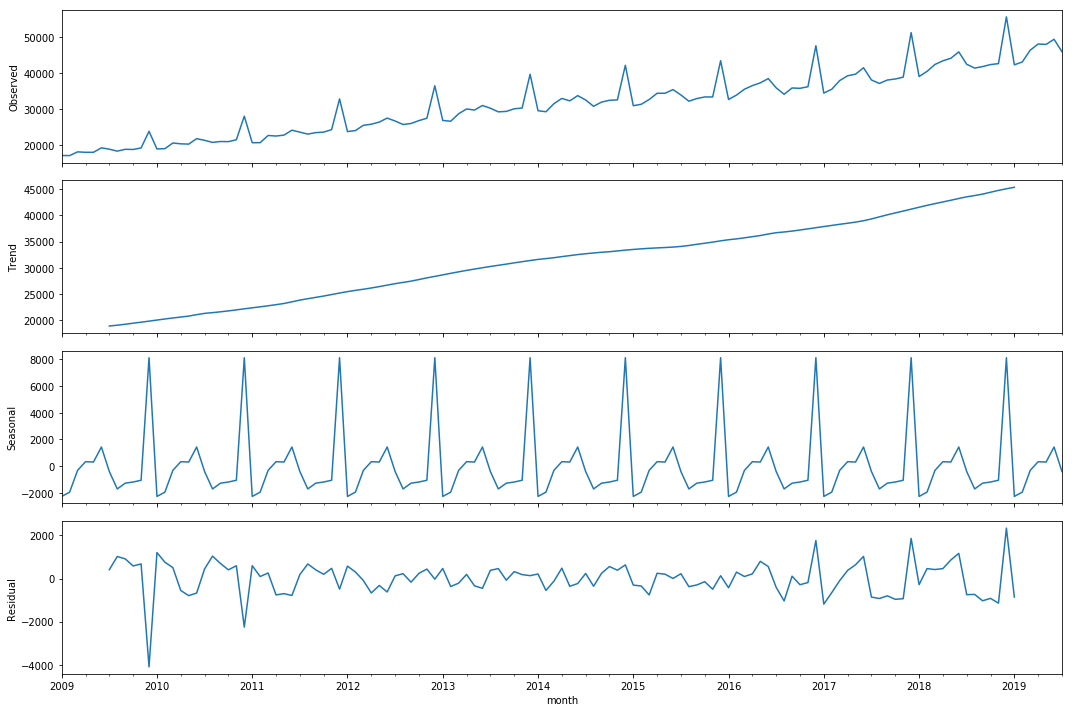

In [86]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])
plt.show()

Стабилизируем дисперсию ряда с помощью преобразования Бокса-Кокса. Критерий Дики-Фуллера по-прежнему не отвергает гипотезу о нестационарности с достаточно высоким p-value, ведь у ряда всё ещё ярко выраженный тренд.

Оптимальный параметр преобразования Бокса-Кокса: 0.391727
Критерий Дики-Фуллера: p=0.776909


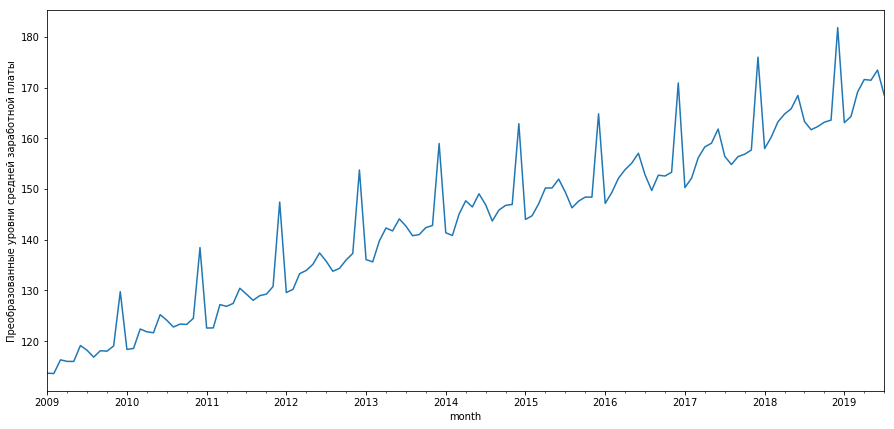

In [87]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.WAG_C_M_box.plot()
plt.ylabel(u'Преобразованные уровни средней заработной платы')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

Так как у нашего ряда ярко выраженная сезонность, применим к нему сначала сезонное дифференцирование. Ряд всё ещё нестационарный. Критерий Дики-Фуллера имеет $p = 0.160214$.

Критерий Дики-Фуллера: p=0.160214


<Figure size 1080x720 with 0 Axes>

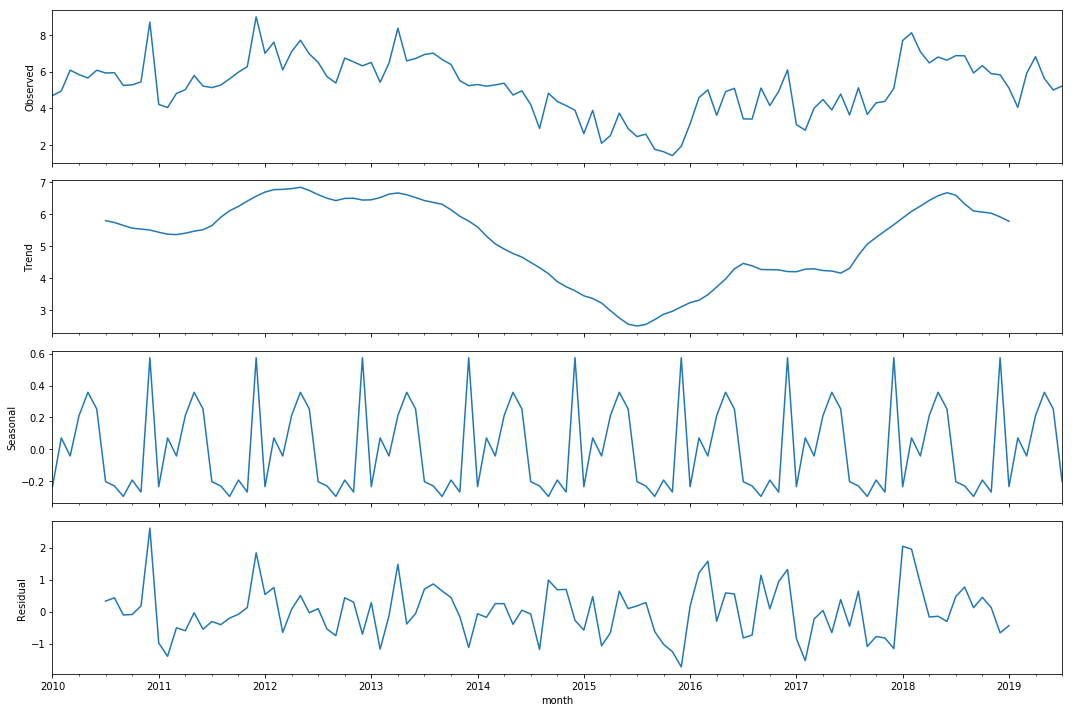

In [88]:
data['WAG_C_M_box_diff'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff[12:])[1])

Проводим дифференцирование ряда ещё раз. На этот раз критерий Дики-Фуллера уверенно отвергает гипотезу о нестационарности ряда.

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

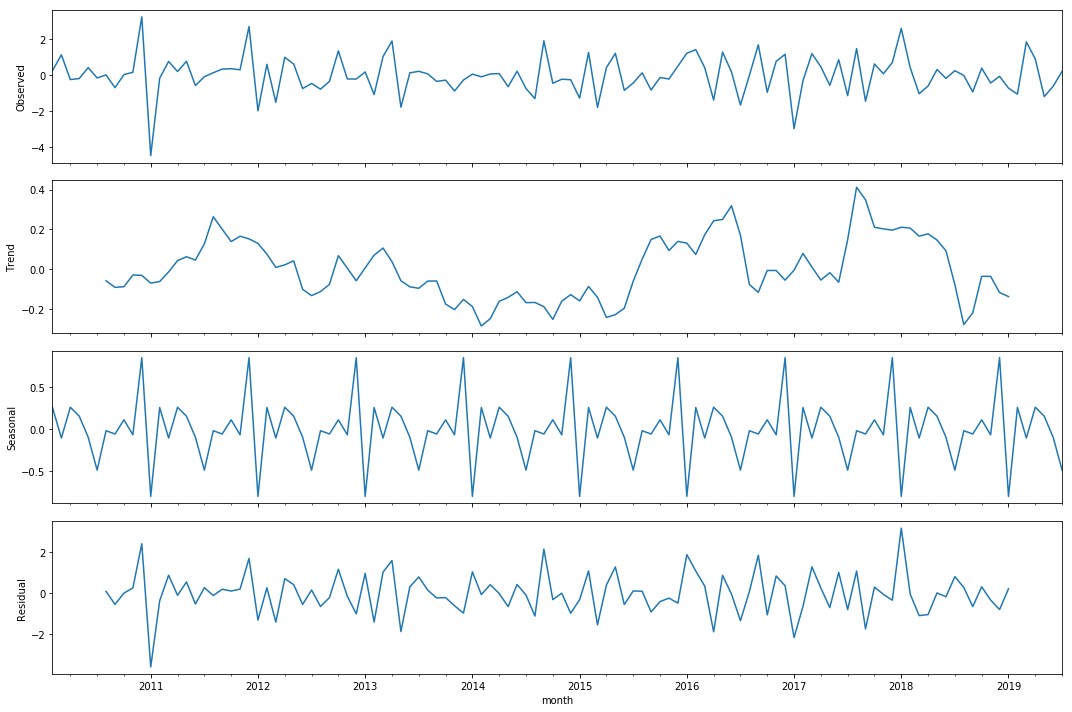

In [89]:
data['WAG_C_M_box_diff2'] = data.WAG_C_M_box_diff - data.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff2[13:])[1])

Построим и проанализируем кореллограммы.

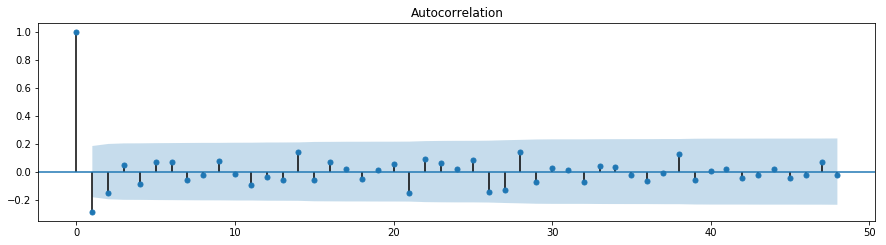

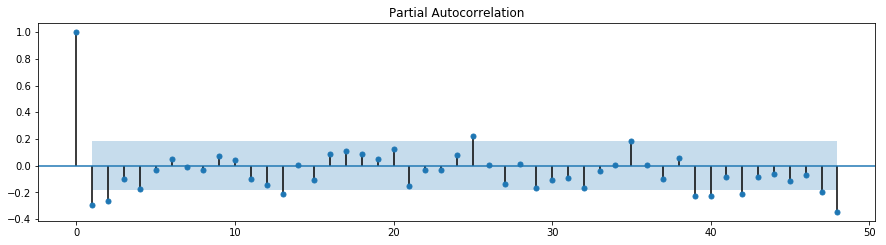

In [90]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: $Q = 0, q = 1, P = 4, p = 4$

In [91]:
ps = range(0, 5)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [92]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

50

Проведём обучение моделей по 50 созданным наборам параметров и выберем ту, которая лучше минимизирует информационный критерий Акаике.

In [93]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 40.7 s


In [94]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
15  (1, 1, 0, 0)  325.909090
5   (0, 1, 0, 0)  326.193282
6   (0, 1, 1, 0)  326.465272
16  (1, 1, 1, 0)  326.796156
25  (2, 1, 0, 0)  327.279201


In [95]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  127
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 12)   Log Likelihood                -159.955
Date:                            Thu, 05 Sep 2019   AIC                            325.909
Time:                                    11:46:33   BIC                            334.118
Sample:                                01-01-2009   HQIC                           329.240
                                     - 07-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2594      0.179      1.451      0.147      -0.091       0.610
ma.L1         -0.6842      0.161   

Проанализируем остатки полученной модели. Модель стационарна и не содержит автокорреляции, остатки несмещенные, в среднем равны 0. Следовательно, никаких поправок вносить не требуется.

Критерий Стьюдента: p=0.896526
Критерий Дики-Фуллера: p=0.000000


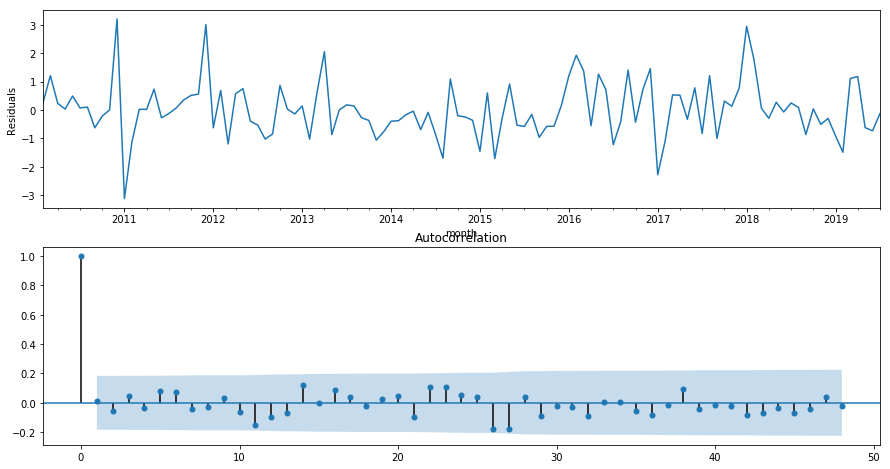

In [96]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Как можно заметить, полученная модель хорошо аппроксимирует данный нам временной ряд.

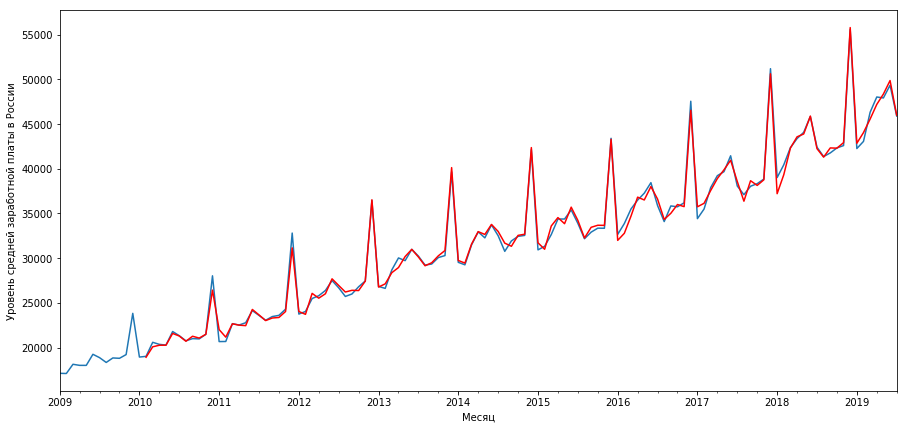

In [97]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel(u'Уровень средней заработной платы в России')
plt.xlabel(u'Месяц')
pylab.show()

На данном графике изображён прогноз уровня средней заработной платы в России на следующие 3 года. Пик роста заработной платы в году приходится обычно на декабрь, так же заметен менее выраженный пик в период май-июнь. Скорее всего это связано с выплатой отпускных.

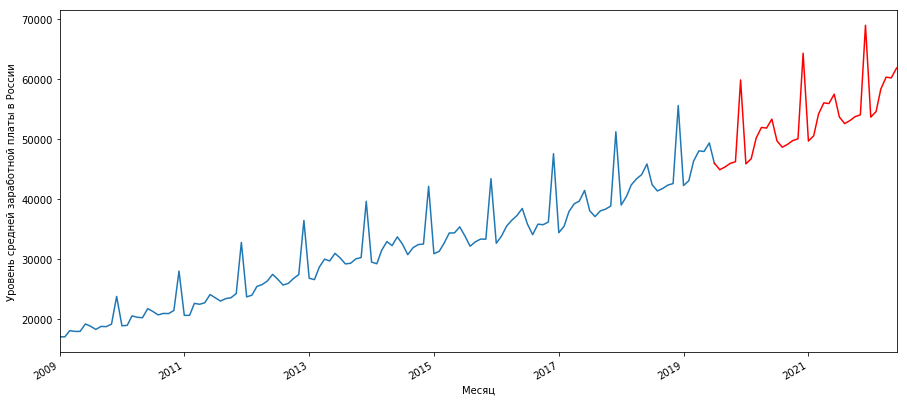

In [98]:
data_with_pred = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2019-07-01", "%Y-%m-%d") + relativedelta(months = x) for x in range(0,36)]
future = pd.DataFrame(index = date_list, columns = data_with_pred.columns)
data_with_pred = pd.concat([data_with_pred, future])
data_with_pred['forecast'] = invboxcox(best_model.predict(start=126, end=162), lmbda)

plt.figure(figsize(15,7))
data_with_pred.WAG_C_M.plot()
data_with_pred.forecast.plot(color='r')
plt.ylabel(u'Уровень средней заработной платы в России')
plt.xlabel(u'Месяц')
pylab.show()